In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Multiply, UpSampling2D, Concatenate, Input
import numpy as np
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import h5py 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import segmentation_models as sm
from tensorflow.keras.applications import ResNet50


Segmentation Models: using `keras` framework.


In [2]:
# 1. 定义 RFB_modified 模块
class RFB_modified(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 四个并行分支
        self.branch0 = models.Sequential([
            Conv2D(out_channels, 1, padding='same'),
            BatchNormalization(), ReLU()
        ])
        self.branch1 = models.Sequential([
            Conv2D(out_channels, 1, padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (1,3), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (3,1), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, 3, padding='same', dilation_rate=3),
            BatchNormalization(), ReLU()
        ])
        self.branch2 = models.Sequential([
            Conv2D(out_channels, 1, padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (1,5), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (5,1), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, 3, padding='same', dilation_rate=5),
            BatchNormalization(), ReLU()
        ])
        self.branch3 = models.Sequential([
            Conv2D(out_channels, 1, padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (1,7), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, (7,1), padding='same'),
            BatchNormalization(), ReLU(),
            Conv2D(out_channels, 3, padding='same', dilation_rate=7),
            BatchNormalization(), ReLU()
        ])
        # 融合与残差
        self.conv_cat = Conv2D(out_channels, 3, padding='same')
        self.bn_cat   = BatchNormalization()
        self.relu_cat = ReLU()
        self.conv_res = Conv2D(out_channels, 1, padding='same')
        self.bn_res   = BatchNormalization()
        self.relu     = ReLU()

    def call(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = Concatenate()([x0, x1, x2, x3])
        x_cat = self.conv_cat(x_cat)
        x_cat = self.bn_cat(x_cat)
        x_cat = self.relu_cat(x_cat)
        res   = self.conv_res(x)
        res   = self.bn_res(res)
        return self.relu(x_cat + res)

In [3]:
# 2. 定义 Aggregation 模块
class Aggregation(tf.keras.layers.Layer):
    def __init__(self, channel):
        super().__init__()
        self.conv_upsample1 = Conv2D(channel, 3, padding='same')
        self.conv_upsample2 = Conv2D(channel, 3, padding='same')
        self.conv_upsample3 = Conv2D(channel, 3, padding='same')
        self.conv_concat2   = Conv2D(channel, 3, padding='same')
        self.conv_concat3   = Conv2D(channel, 3, padding='same')
        self.conv4          = Conv2D(channel, 3, padding='same')
        self.conv5          = Conv2D(1,       1, padding='same')

    def call(self, x1, x2, x3):
        x2_1 = self.conv_upsample1(UpSampling2D(2)(x1)) * x2
        x3_1 = self.conv_upsample2(UpSampling2D(2)(x2_1)) * \
               self.conv_upsample3(UpSampling2D(4)(x1)) * x3
        x2_2 = Concatenate()([x2_1, UpSampling2D(2)(x1)])
        x2_2 = self.conv_concat2(x2_2)
        x3_2 = Concatenate()([x3_1, UpSampling2D(2)(x2_2)])
        x3_2 = self.conv_concat3(x3_2)
        x    = self.conv4(x3_2)
        return self.conv5(x)

In [4]:
# 3. 定义 ReverseAttention 模块
class ReverseAttention(tf.keras.layers.Layer):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = Conv2D(in_channels, 3, padding='same')
        self.conv2 = Conv2D(in_channels, 3, padding='same')
        self.conv3 = Conv2D(1,           3, padding='same')

    def call(self, x, y):
        # 将粗预测 y 缩放到 x 的尺寸
        y_resized = tf.image.resize(y, tf.shape(x)[1:3], method='bilinear')
        reverse   = 1 - tf.sigmoid(y_resized)
        x_att     = x * reverse
        x_att     = self.conv1(x_att)
        x_att     = self.conv2(x_att)
        x_att     = self.conv3(x_att)
        return x_att + y_resized

In [5]:
# 4. 构建 ResNet50 主干
def build_backbone(input_shape):
    base = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', input_shape=input_shape
    )
    # C2,C3,C4,C5 分别对应下采样 4,8,16,32 倍之后的特征图
    return models.Model(
        inputs=base.input,
        outputs=[
            base.get_layer('conv2_block3_out').output,
            base.get_layer('conv3_block4_out').output,
            base.get_layer('conv4_block6_out').output,
            base.get_layer('conv5_block3_out').output
        ]
    )

In [6]:
# 5. 构建完整 PraNet 模型，动态 resize 输出
def build_pranet(input_shape=(288, 384, 3), channel=32):
    inputs   = Input(shape=input_shape)
    c2, c3, c4, c5 = build_backbone(input_shape)(inputs)

    r2 = RFB_modified(512, channel)(c2)
    r3 = RFB_modified(1024, channel)(c3)
    r4 = RFB_modified(2048, channel)(c4)
    agg = Aggregation(channel)(r4, r3, r2)

    ra4 = ReverseAttention(2048)(c4, agg)
    ra3 = ReverseAttention(1024)(c3, ra4)
    ra2 = ReverseAttention(512,)(c2, ra3)

    # 动态 resize：直接将所有输出对齐到原始输入大小
    target_size = tf.shape(inputs)[1:3]
    agg_up = tf.image.resize(agg, target_size, method='bilinear')
    ra4_up = tf.image.resize(ra4, target_size, method='bilinear')
    ra3_up = tf.image.resize(ra3, target_size, method='bilinear')
    ra2_up = tf.image.resize(ra2, target_size, method='bilinear')

    outputs = [
        tf.keras.activations.sigmoid(ra2_up)
    ]

    return models.Model(inputs=inputs, outputs=outputs)

In [7]:
# Instantiate with your data size (e.g. 288×384×3)
model = build_pranet(input_shape=(288, 384, 3), channel=32)
# This will show you each layer’s output shape and total parameters
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 72, 96, 256  23587712    ['input_1[0][0]']                
                                ),                                                                
                                 (None, 36, 48, 512                                               
                                ),                                                                
                                 (None, 18, 24, 102                                         

In [8]:
# 可视化模型结构（需要graphviz）
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='PraNet.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [8]:
fh5 = h5py.File(r'E:\wujieyu\img train PolypGen+CVC\img Highlights processing FMM\imgandmasks_Highlights_processing_percentile=99.5.h5','r')
img_png_x = fh5['img']
img_png_x = np.array(img_png_x)
mask_x = fh5['masks']
mask_x = np.array(mask_x)

In [9]:
mask_x  = mask_x .reshape(len(mask_x), 288, 384, 1)
# mask_x = mask_x/255
mask_x .shape

(2987, 288, 384, 1)

In [10]:
img_png_x.max()

1.0

In [11]:
mask_x.max()

1.0

(-0.5, 383.5, 287.5, -0.5)

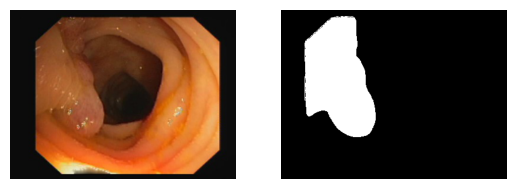

In [12]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_x[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_x[a],'gray')
plt.axis('off')

In [13]:
# -----------------------------------------------------------------
# 从txt文件读取并恢复为NumPy数组
# -----------------------------------------------------------------
# 读取训练集
# Train = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Train.txt', dtype=int)
Train = np.loadtxt('D:\edge\Train.txt', dtype=int)
# 读取验证集
# Val = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Val.txt', dtype=int)
Val = np.loadtxt('D:\edge\Val.txt', dtype=int)

In [14]:
# -----------------------------------------------------------------
# 按索引划分图像数据
# -----------------------------------------------------------------
# 划分训练集（T_img_png_x）和验证集（V_img）
T_img = img_png_x[Train]
V_img = img_png_x[Val]
T_mask = mask_x[Train]
V_mask = mask_x[Val]

(-0.5, 383.5, 287.5, -0.5)

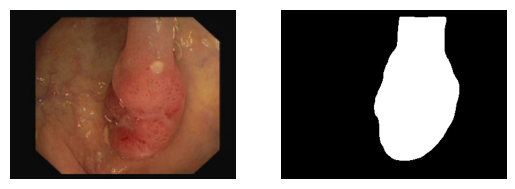

In [15]:
# 查看训练集集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(T_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(T_mask[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

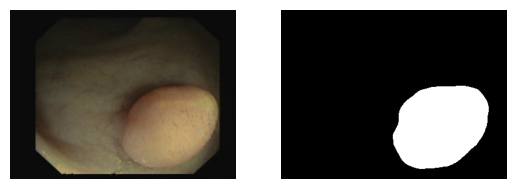

In [16]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(V_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(V_mask[a],'gray')
plt.axis('off')

In [8]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [18]:
import keras
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(  monitor='val_iou_score',  # 监控指标（默认：val_loss）
                                        factor=0.5,               # 学习率衰减系数（新学习率 = 旧学习率 * factor）
                                        patience=20,              # 等待 epoch 数无改善后触发
                                        mode='max'              # 监控指标方向：'auto'/'min'/'max'（自动检测最大/最小化）
                                        # min_delta=0.0001,         # 视为“改善”的最小变化阈值
                                        # cooldown=0,               # 触发后暂停监控的 epoch 数（防止频繁调整）
                                        # min_lr=0                  # 学习率下限（避免过小导致训练停滞）
                                     ),

    
    keras.callbacks.ModelCheckpoint(filepath=r'E:\wujieyu\IoU best\PraNet\FMM+percentile=99.5（1）\img_FMM+percentile=99.5_bestweigh_epoch_{epoch:03d}_val_iou_{val_iou_score:.4f}.h5', 
                                    # 保存路径（支持 epoch 变量，如 model_{epoch:02d}.h5）
                                    monitor='val_iou_score',
                                    save_best_only=True,           # 只保留最优模型
                                    save_weights_only=True,       # 若为 True 只保存权重，否则保存完整模型
                                    mode='max'                   # 监控指标方向（与 ReduceLROnPlateau 相同）
                                   )   ##保存最佳模型
                                      
    #keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', 
                                  #baseline=None, restore_best_weights=False)
    ]

In [19]:

# 模型训练
model.fit(
       x=T_img,
       y=T_mask,
       # validation_split=0.2,  # 验证集
       batch_size=2,
       epochs=300,
       validation_data=(V_img, V_mask),
       callbacks = callbacks_list
)

Epoch 1/300
1195/1195 [==============================] - 156s 118ms/step - loss: 17.2317 - iou_score: 0.1258 - val_loss: 3.2722 - val_iou_score: 0.2133 - lr: 0.0010
Epoch 2/300
1195/1195 [==============================] - 141s 117ms/step - loss: 1.4216 - iou_score: 0.2136 - val_loss: 1.9110 - val_iou_score: 0.2337 - lr: 0.0010
Epoch 3/300
1195/1195 [==============================] - 131s 109ms/step - loss: 1.1433 - iou_score: 0.2584 - val_loss: 1.8047 - val_iou_score: 0.1090 - lr: 0.0010
Epoch 4/300
1195/1195 [==============================] - 141s 118ms/step - loss: 0.9873 - iou_score: 0.3128 - val_loss: 1.0317 - val_iou_score: 0.3123 - lr: 0.0010
Epoch 5/300
1195/1195 [==============================] - 142s 119ms/step - loss: 0.9064 - iou_score: 0.3589 - val_loss: 1.0638 - val_iou_score: 0.3582 - lr: 0.0010
Epoch 6/300
1195/1195 [==============================] - 131s 109ms/step - loss: 136.0161 - iou_score: 0.3898 - val_loss: 177635707516141257428566016.0000 - val_iou_score: 0.1213 

In [20]:
model.save_weights(r'E:\wujieyu\IoU best\PraNet\FMM+percentile=99.5（1）\300img_FMM+percentile=99.5_weigh.h5')
# #路径文件名

In [8]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\images\test_CVC-ColonDB_imgandmasks.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c = fh5['img']
img_png_c = np.array(img_png_c)
mask_c = fh5['masks']
mask_c = np.array(mask_c)

In [9]:
img_png_c[1].max()

1.0

In [10]:
mask_c[1].max()

255.0

In [11]:
mask_c = mask_c/255
mask_c[1].max()

1.0

In [12]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\img Highlights processing FMM\test_CVC-ColonDB_imgandmasks_Highlights_percentile=99.5.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c1 = fh5['img']
img_png_c1 = np.array(img_png_c1)
mask_c1 = fh5['masks']
mask_c1 = np.array(mask_c1)

In [13]:
img_png_c1.max()

1.0

In [14]:
mask_c1[1].max()

1.0

(-0.5, 383.5, 287.5, -0.5)

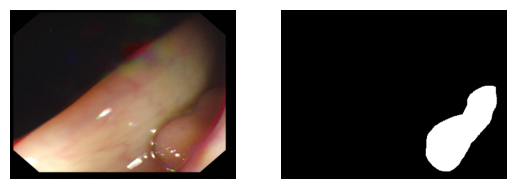

In [15]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

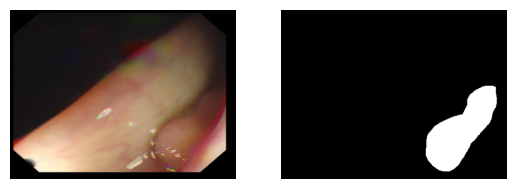

In [16]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c1[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c1[a],'gray')
plt.axis('off')

In [17]:
import tensorflow as tf

def bce_jaccard_loss(y_true, y_pred, smooth=1e-7, alpha=0.5):
    """
    参数说明：
    - y_true: 真实标签 (shape=[batch, H, W, 1])
    - y_pred: 模型预测值 (shape=[batch, H, W, 1])
    - smooth: 防止除零的小常数
    - alpha: 平衡 BCE 和 Jaccard 的权重（默认 0.5）
    """
    # 计算二元交叉熵
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # 计算 Jaccard Loss (IoU Loss)  
    y_true_f = tf.keras.backend.flatten(y_true)   # 展平为向量 [batch*H*W]
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard  # 将 IoU 转换为 Loss
    
    # 加权组合
    return alpha * bce + (1 - alpha) * jaccard_loss

In [20]:
def dice_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * intersection + smooth) / (denominator + smooth)

In [21]:
# def iou_score(y_true, y_pred, smooth=1e-7):
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
#     return (intersection + smooth) / (union + smooth)

In [22]:
model.compile(
    optimizer='Adam',
    loss=bce_jaccard_loss,  # 可替换为 iou_loss 或 bce_jaccard_loss
    metrics=[
        dice_score, 
        sm.metrics.iou_score
        # tf.keras.metrics.BinaryAccuracy()  # 可选：添加准确率指标
    ]
)

In [23]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\PraNet\img\img_bestweigh_epoch_276_val_iou_0.6571.h5', by_name=True)

In [24]:
# 原图评估模型（返回 loss + metrics）
results = model.evaluate(img_png_c, mask_c, verbose=0)

In [25]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results[0]:.4f}")
print(f"dice_score: {results[1]:.4f}")
print(f"iou_score: {results[2]:.4f}")


=== 测试结果 ===
Loss: 0.5440
dice_score: 0.6688
iou_score: 0.5282


In [26]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\PraNet\FMM+percentile=99.5\img_FMM+percentile=99.5_bestweigh_epoch_231_val_iou_0.6867.h5', by_name=True)

In [27]:
# 新方法评估模型（返回 loss + metrics）
results1 = model.evaluate(img_png_c1, mask_c1, verbose=0)

In [38]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results1[0]:.4f}")
print(f"dice_score: {results1[1]:.4f}")
print(f"iou_score: {results1[2]:.4f}")


=== 测试结果 ===
Loss: 0.4958
dice_score: 0.6773
iou_score: 0.5356


In [17]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\PraNet\img\img_bestweigh_epoch_276_val_iou_0.6571.h5', by_name=True)

In [18]:
#测试mask
imgp = model.predict(img_png_c, verbose=1)

12/12 [==============================] - 13s 464ms/step


In [19]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\PraNet\FMM+percentile=99.5\img_FMM+percentile=99.5_bestweigh_epoch_231_val_iou_0.6867.h5', by_name=True)

In [20]:
#测试mask
imgp1 = model.predict(img_png_c1, verbose=1)

12/12 [==============================] - 2s 163ms/step


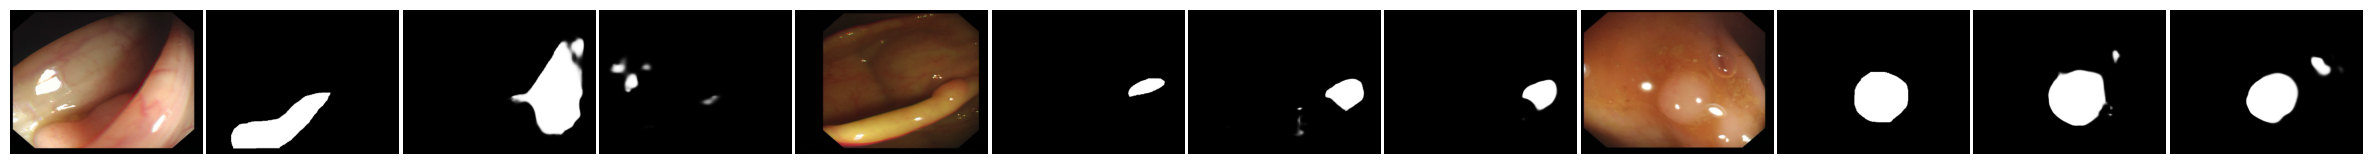

In [21]:
a, b, c = 8, 117, 311

# 设置更大的画布和紧凑布局
plt.figure(figsize=(24, 6))  # 宽度增加，高度适当调整
plt.subplots_adjust(wspace=0.02, 
                    left=0.01, 
                    right=0.99, 
                    top=0.5, 
                    bottom=0.05)  # 调整左右边距和子图间距

# 第1组子图
plt.subplot(1,12,1)
plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(1,12,2)
plt.imshow(mask_c[a], 'gray')
plt.axis('off')
plt.subplot(1,12,3)
plt.imshow(imgp[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,4)
plt.imshow(imgp1[a].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第2组子图
plt.subplot(1,12,5)
plt.imshow(img_png_c[b])
plt.axis('off')
plt.subplot(1,12,6)
plt.imshow(mask_c[b], 'gray')
plt.axis('off')
plt.subplot(1,12,7)
plt.imshow(imgp[b].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,8)
plt.imshow(imgp1[b].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第3组子图
plt.subplot(1,12,9)
plt.imshow(img_png_c[c])
plt.axis('off')
plt.subplot(1,12,10)
plt.imshow(mask_c[c], 'gray')
plt.axis('off')
plt.subplot(1,12,11)
plt.imshow(imgp[c].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,12)
plt.imshow(imgp1[c].reshape(288, 384), cmap='gray')
plt.axis('off')

plt.show()

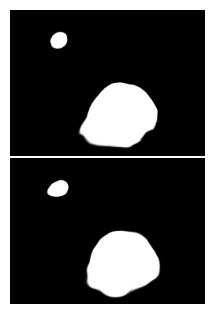

In [45]:
a = 340
# 创建紧凑画布
fig = plt.figure(figsize=(6, 3))

# 使用GridSpec控制微小边距
gs = fig.add_gridspec(2, 1, 
                     hspace=0.02,  # 行间距
                     left=0.01,    # 左边距
                     right=0.99,   # 右边距
                     top=0.99,     # 上边距
                     bottom=0.01)  # 下边距

# 添加图像子图
ax1 = fig.add_subplot(gs[0])
ax1.imshow(imgp[a].reshape(288, 384), 'gray')
ax1.axis('off')
ax1.margins(0.01)  # 图像周围微小边距

ax2 = fig.add_subplot(gs[1])
ax2.imshow(imgp1[a].reshape(288, 384), 'gray')
ax2.axis('off')
ax2.margins(0.01)  # 图像周围微小边距

# 显示紧凑布局
plt.show()